In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from toolz.curried import *

# Gerando os Dados

In [2]:
def make_confounded_data(N):

    def get_severity(df):
        return ((np.random.beta(1, 3, size=df.shape[0]) * (df["age"] < 30)) +
                (np.random.beta(3, 1.5, size=df.shape[0]) * (df["age"] >= 30)))

    def get_treatment(df):
        return (.33 * df["sex"] +
                1.5 * df["severity"] +
                0.15 * np.random.normal(size=df.shape[0]) > 0.8).astype(float)

    def get_recovery(df):
        return np.random.poisson(np.exp(2 +
                                        0.5 * df["sex"] +
                                        0.03 * df["age"] +
                                        df["severity"] -
                                        df["medication"]))

    np.random.seed(1111)
    sexes = np.random.randint(0, 2, size=N)
    ages = np.random.gamma(8, scale=4, size=N)
    meds = np.random.randint(0, 2, size=N)

    # dados com designação aleatória
    df_rnd = pd.DataFrame(dict(sex=sexes, age=ages, medication=meds))
    df_rnd['severity'] = get_severity(df_rnd)
    df_rnd['recovery'] = get_recovery(df_rnd)

    features = ['sex', 'age', 'severity', 'medication', 'recovery']
    df_rnd = df_rnd[features]  # to enforce column order

    # dados observacionais
    df_obs = df_rnd.copy()
    df_obs['medication'] = get_treatment(df_obs)
    df_obs['recovery'] = get_recovery(df_obs)

    # dados contrafactuais data
    df_ctf = df_obs.copy()
    df_ctf['medication'] = ((df_ctf['medication'] == 1) ^ 1).astype(float)
    df_ctf['recovery'] = get_recovery(df_ctf)

    return df_rnd, df_obs, df_ctf

true_efect = np.exp(-1.0)

In [3]:
df_rnd, df_obs, df_ctf = make_confounded_data(50000)
_, test_obs, _ = make_confounded_data(10000)

In [4]:
df_obs.head()

,sex,age,severity,medication,recovery
0,0,16.354103,0.047350,0.0,14
1,1,24.182983,0.099184,0.0,27
2,1,25.483159,0.349073,1.0,14
3,1,52.195765,0.536694,1.0,26
4,0,48.816918,0.631806,1.0,28


## Designação Aleatória

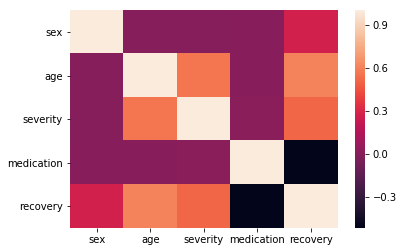

In [5]:
sns.heatmap(df_rnd.corr())
plt.show()

## Designação com Confusão

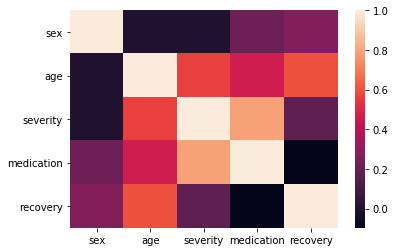

In [6]:
sns.heatmap(df_obs.corr())
plt.show()

# Modelo Sem Contrafactual

In [7]:
from sklearn.ensemble import RandomForestRegressor

var_x = ["sex", "age", "severity"]
var_t = ["medication"]
resp_y = "recovery"

In [8]:
regr = RandomForestRegressor(n_estimators=100, max_depth=4, min_samples_leaf=100)
regr.fit(df_obs[var_x + var_t], df_obs[resp_y])

print("Train Score: ", regr.score(df_obs[var_x + var_t], df_obs[resp_y]))
print("Test Score: ", regr.score(test_obs[var_x + var_t], test_obs[resp_y]))

Train Score:  0.6842113937428888
Test Score:  0.6756330521689281


### Prevendo o Efeito Causal

In [9]:
X_neg = df_obs.copy()
X_pos = df_obs.copy()

X_neg["medication"] = 0
X_pos["medication"] = 1

preds = regr.predict(X_pos[var_x + var_t]) / regr.predict(X_neg[var_x + var_t])
print("Efeito Causal Previsto:, ", preds.mean())

Efeito Causal Previsto:,  0.6286014281347522


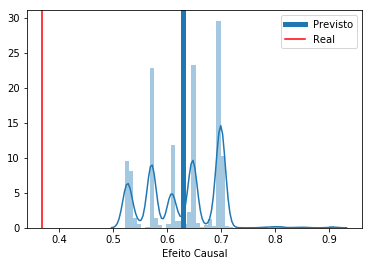

In [10]:
ax = sns.distplot(preds)
plt.axvline(np.mean(preds), label='Previsto', lw=5)
plt.axvline(true_efect, color='r', label='Real')
ax.set_xlabel('Efeito Causal')
plt.legend()
plt.show()

In [11]:
print("Score Contrafactual: ", regr.score(df_ctf[var_x + var_t], df_ctf[resp_y]))

Score Contrafactual:  0.5286251438622127


### Em Dados Aleatórios

In [12]:
regr = RandomForestRegressor(n_estimators=100, max_depth=4, min_samples_leaf=100)
regr.fit(df_rnd[var_x + var_t], df_rnd[resp_y])
regr.score(df_rnd[var_x + var_t], df_rnd[resp_y])

0.810008266401398

In [13]:
X_neg = df_obs.copy()
X_pos = df_obs.copy()

X_neg["medication"] = 0
X_pos["medication"] = 1

preds = regr.predict(X_pos[var_x + var_t]) / regr.predict(X_neg[var_x + var_t])
print("Efeito Causal Previsto:, ", preds.mean())

Efeito Causal Previsto:,  0.37125007321366865


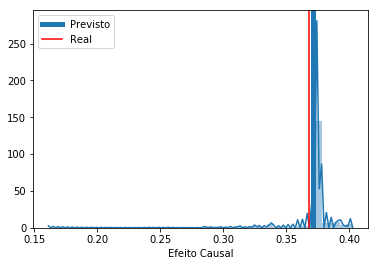

In [14]:
ax = sns.distplot(preds)
plt.axvline(np.mean(preds), label='Previsto', lw=5)
plt.axvline(true_efect, color='r', label='Real')
ax.set_xlabel('Efeito Causal')
plt.legend()
plt.show()

# Modelo Contrafactual

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

ps_model = CalibratedClassifierCV(RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_leaf=100))
ps_model.fit(df_obs[var_x], df_obs[var_t].squeeze())

print("Train Score: ", ps_model.score(df_obs[var_x], df_obs[var_t].squeeze()))
print("Train Score: ", ps_model.score(test_obs[var_x], test_obs[var_t].squeeze()))

Train Score:  0.9215
Train Score:  0.9254


## Checando Positividade

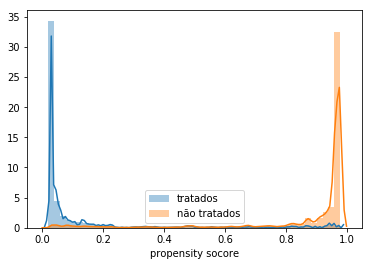

In [16]:
ps_score = pd.DataFrame(ps_model.predict_proba(df_obs[var_x]))
ps_data = df_obs.assign(propensity_score = ps_score[0])

ax = sns.distplot(ps_data.query("medication==1.0")["propensity_score"], label="tratados")
sns.distplot(ps_data.query("medication==0.0")["propensity_score"], label="não tratados")
ax.set_xlabel('propensity socore')
plt.legend()
plt.show()

In [17]:
weight_data = df_obs.assign(weight = 1. / ps_score.lookup(np.arange(ps_score.shape[0]),
                                                          df_obs[var_t].astype(int).values.squeeze()))

weight_data.head()

,sex,age,severity,medication,recovery,weight
0,0,16.354103,0.047350,0.0,14,1.022779
1,1,24.182983,0.099184,0.0,27,1.037767
2,1,25.483159,0.349073,1.0,14,1.640318
3,1,52.195765,0.536694,1.0,26,1.028249
4,0,48.816918,0.631806,1.0,28,1.053678


In [18]:
struc_model = RandomForestRegressor(n_estimators=100, max_depth=7, min_samples_leaf=10)
struc_model.fit(weight_data[var_x + var_t],
                weight_data[resp_y].squeeze(),
                sample_weight=weight_data["weight"])

print("Train Score: ", struc_model.score(weight_data[var_x + var_t], weight_data[resp_y].squeeze()))
print("Train Score: ", struc_model.score(test_obs[var_x + var_t], test_obs[resp_y].squeeze()))

Train Score:  0.8404561549023044
Train Score:  0.8313566196829696


## Prevendo o Efeito Causal

In [19]:
X_neg = df_obs.copy()
X_pos = df_obs.copy()

X_neg["medication"] = 0
X_pos["medication"] = 1

preds = struc_model.predict(X_pos[var_x + var_t]) / struc_model.predict(X_neg[var_x + var_t])
print("Efeito Causal Previsto:, ", preds.mean())

Efeito Causal Previsto:,  0.428171125385169


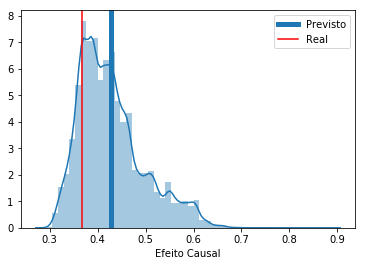

In [20]:
ax = sns.distplot(preds)
plt.axvline(np.mean(preds), label='Previsto', lw=5)
plt.axvline(true_efect, color='r', label='Real')
ax.set_xlabel('Efeito Causal')
plt.legend()
plt.show()

In [21]:
print("Score Contrafactual: ", struc_model.score(df_ctf[var_x + var_t], df_ctf[resp_y]))

Score Contrafactual:  0.8046587777963254
